In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_csv("fish_data.csv")

In [4]:
data.dtypes

,0
species,object
length,float64
weight,float64
w_l_ratio,float64


In [5]:
print(data.isna().sum()) #Считаем количество NaN значений в датасете
print(data.isnull().sum()) #Считаем количество пропусков в датасете

species      0
length       0
weight       0
w_l_ratio    0
dtype: int64
species      0
length       0
weight       0
w_l_ratio    0
dtype: int64


In [6]:
#Преобразуем строковые классы в числовые метки
print(names := np.array(list(zip(data['species'].unique(), [i for i in range(len(data['species'].unique()))]))).reshape(9, 2))

[['Anabas testudineus' '0']
 ['Coilia dussumieri' '1']
 ['Otolithoides biauritus' '2']
 ['Otolithoides pama' '3']
 ['Pethia conchonius' '4']
 ['Polynemus paradiseus' '5']
 ['Puntius lateristriga' '6']
 ['Setipinna taty' '7']
 ['Sillaginopsis panijus' '8']]


In [7]:
data['species'].replace(data['species'].unique(), [i for i in range(len(data['species'].unique()))], inplace = True)

<ipython-input-7-4bca7280e1f8>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['species'].replace(data['species'].unique(), [i for i in range(len(data['species'].unique()))], inplace = True)
<ipython-input-7-4bca7280e1f8>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['species'].replace

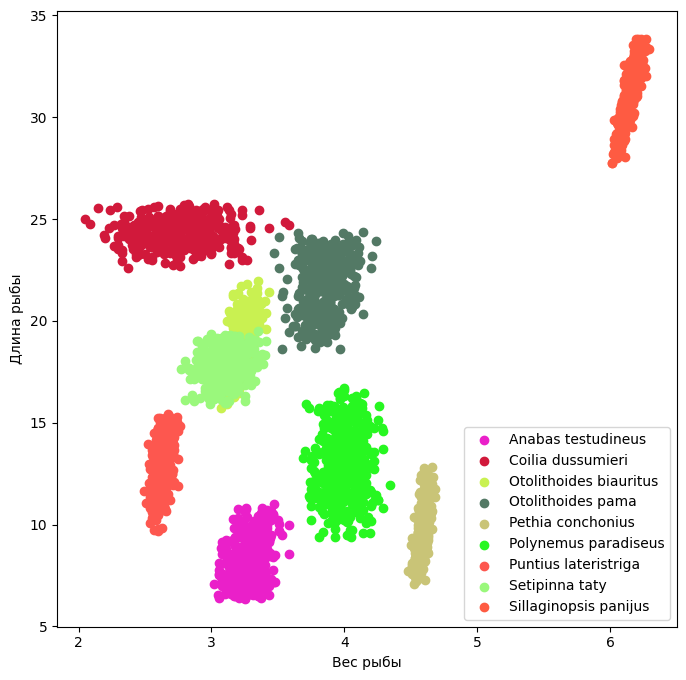

In [8]:
plt.figure(figsize=(8,8))
r = lambda: random.randint(0, 255)
colors = ['#%02X%02X%02X' % (r(), r(), r()) for i in range(len(names))]
for i in range(len(names)):
  temp = data.query(f'species == {names[i][1]}')
  plt.scatter(temp['weight'], temp['length'], label = names[i][0], c=colors[i])
plt.xlabel('Вес рыбы')
plt.ylabel('Длина рыбы')
plt.legend(loc='best')

In [9]:
data.iloc[:,range(1,4)] = StandardScaler().fit_transform(data.iloc[:,range(1,4)]) #Стандартизируем фичи

In [10]:
#Разбиение данных на тестовую и обучающую выборки
x = data.iloc[:,range(1,4)]
y = data.iloc[:,0]
y_bin = label_binarize(y, classes = [*range(len(y.unique()))])
x_train, x_test, y_train, y_test = train_test_split(x, y_bin, test_size = 0.2, random_state = 2024-9-29)

In [11]:
#Мультиклассовая классификация с использованием логистической регрессии
model1 = OneVsRestClassifier(LogisticRegression())
model1.fit(x_train, y_train)
preds1_proba = model1.predict_proba(x_test)
preds1 = model1.predict(x_test)

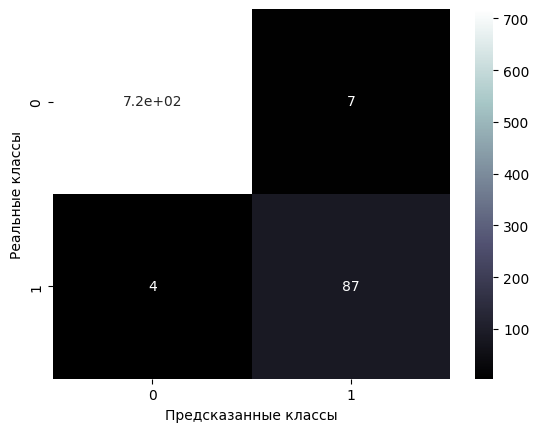

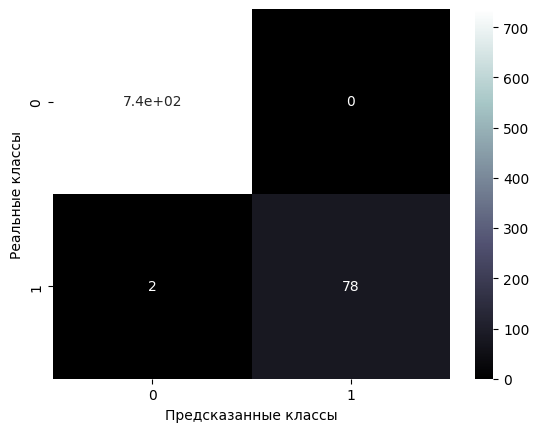

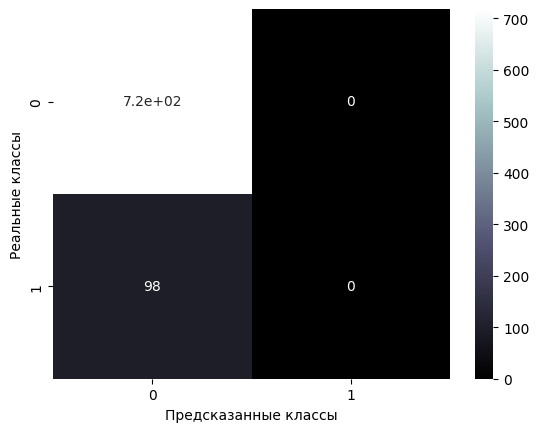

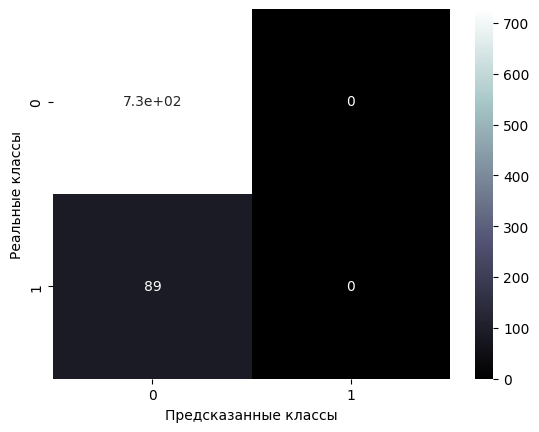

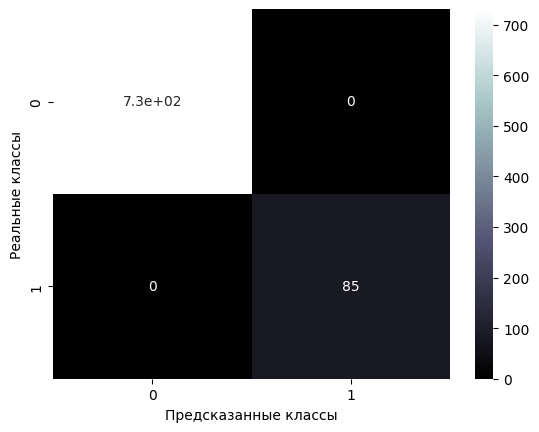

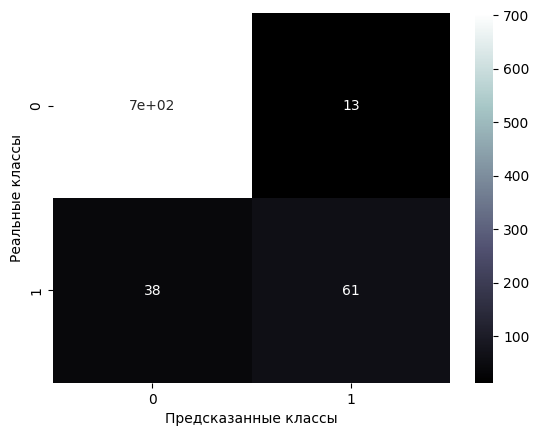

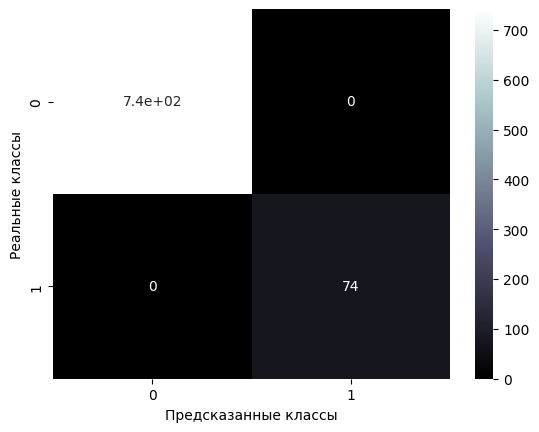

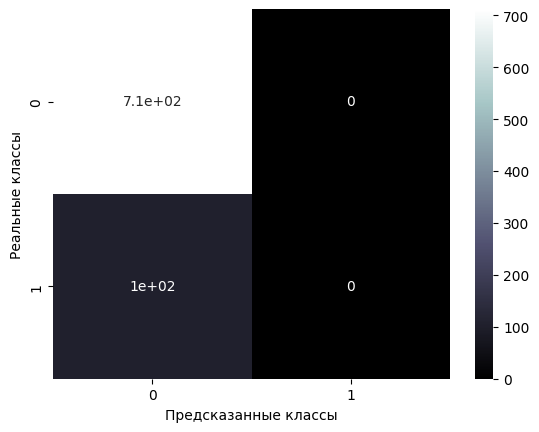

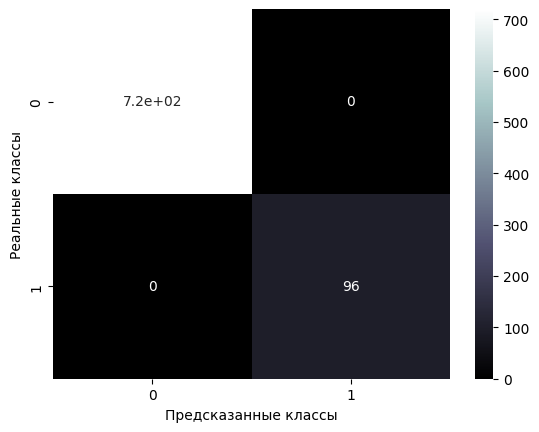

In [12]:
#Матрицы ошибок для задачи классификации по методики OneVsRest
conf_matrix = multilabel_confusion_matrix(y_test, preds1)
for i in range(conf_matrix.shape[0]):
  sns.heatmap(conf_matrix[i], label=True, annot=True, cmap="bone")
  plt.ylabel('Реальные классы')
  plt.xlabel('Предсказанные классы')
  plt.show()

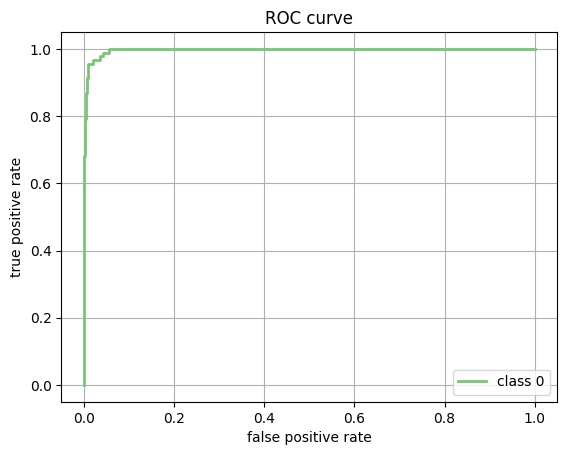

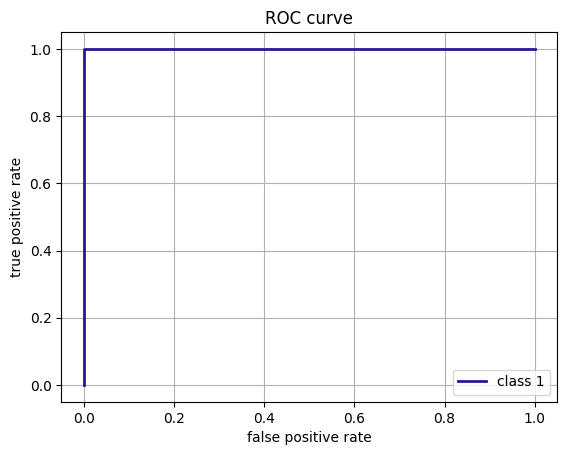

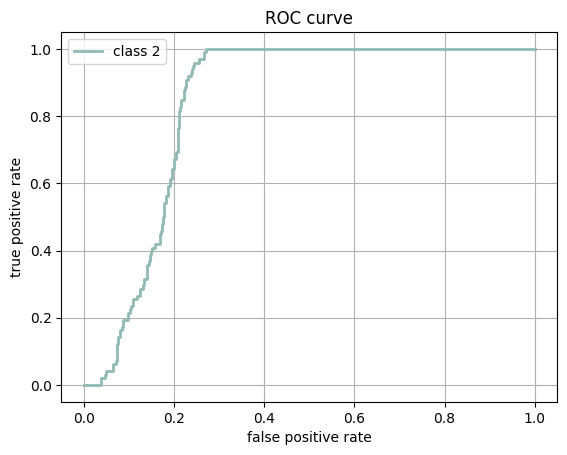

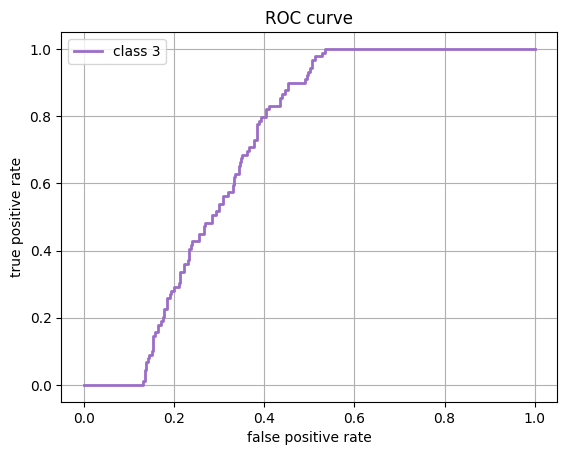

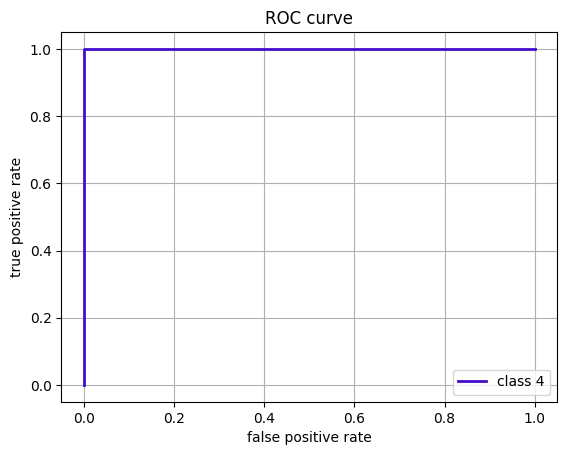

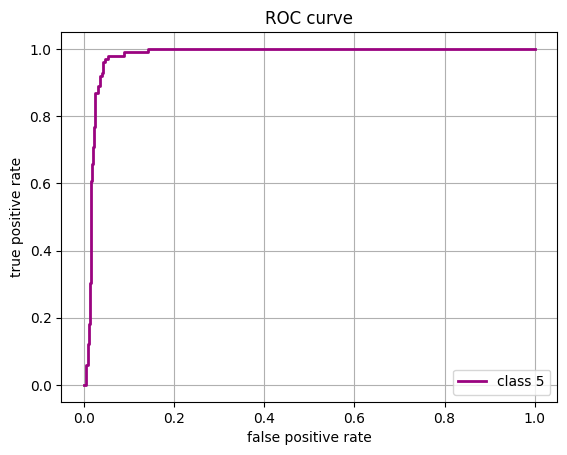

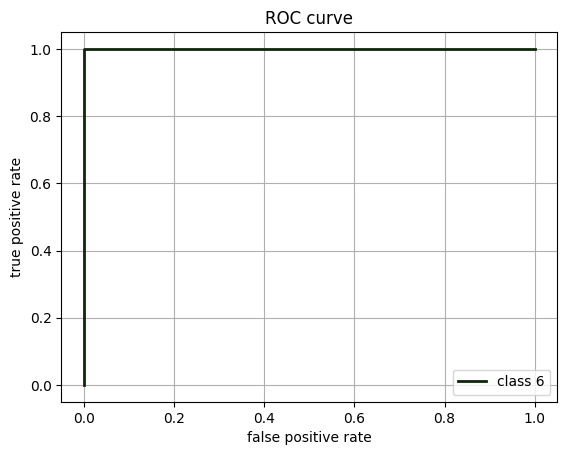

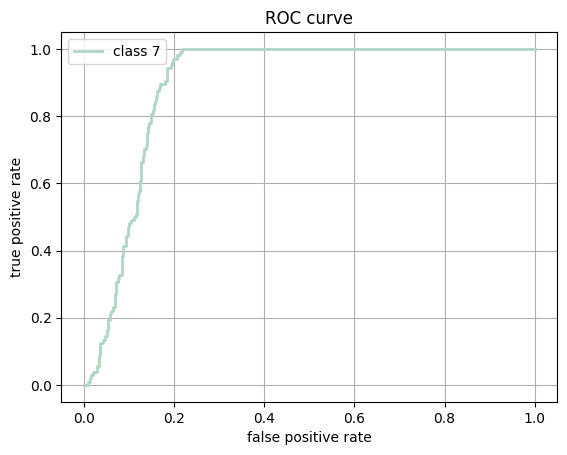

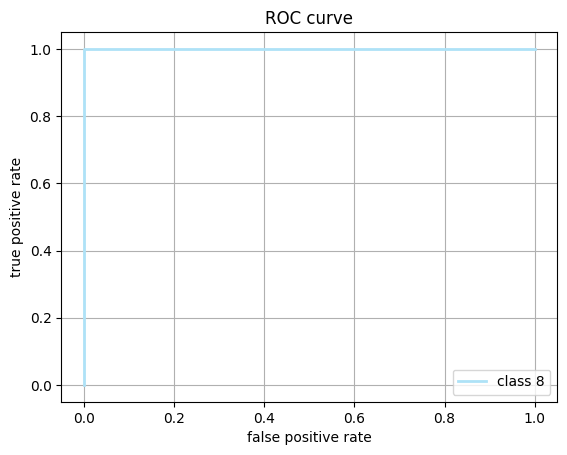

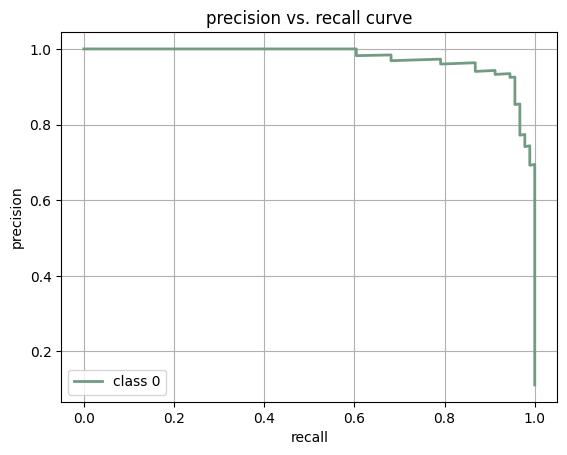

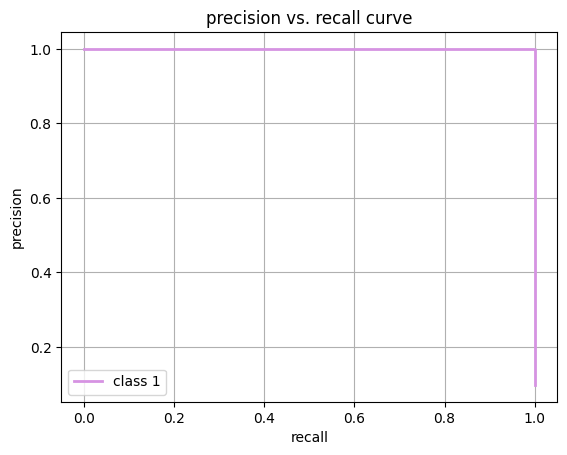

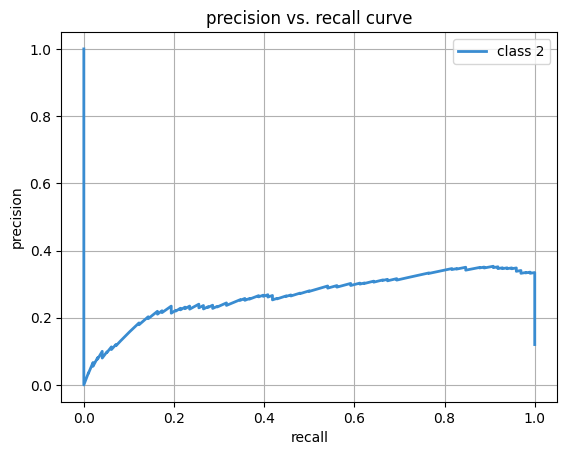

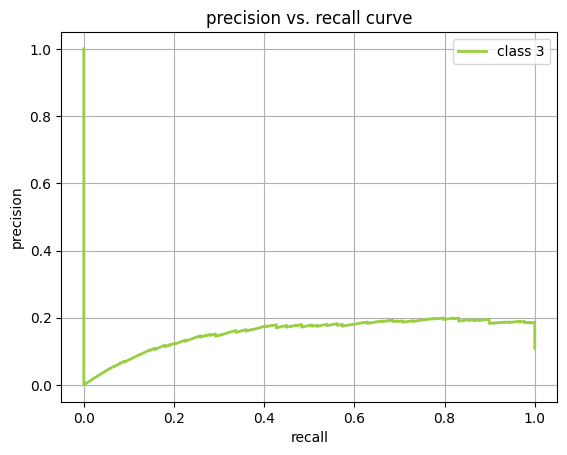

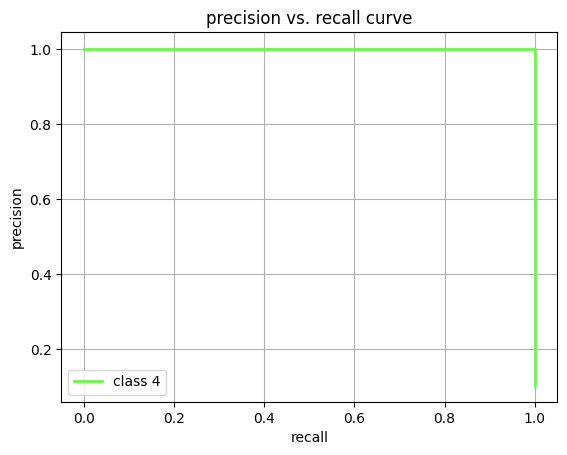

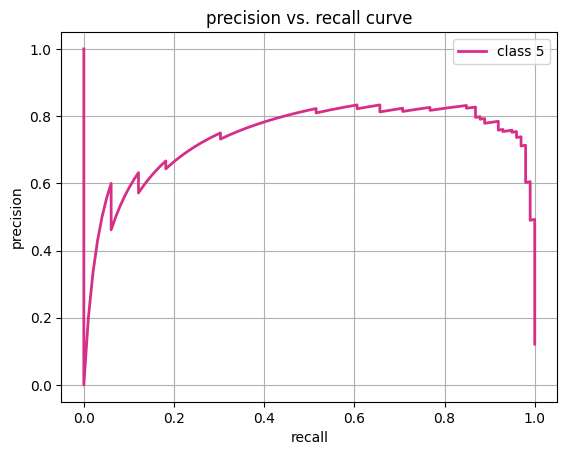

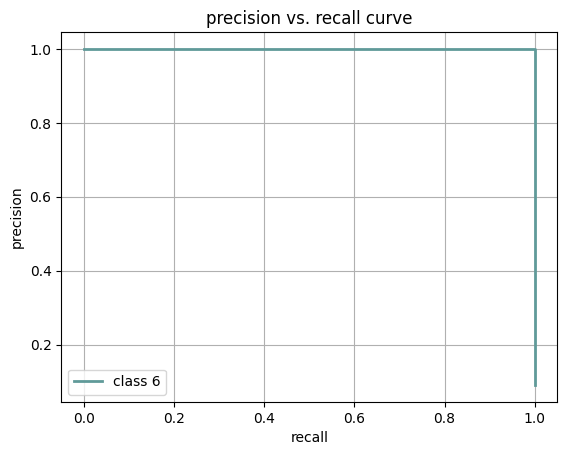

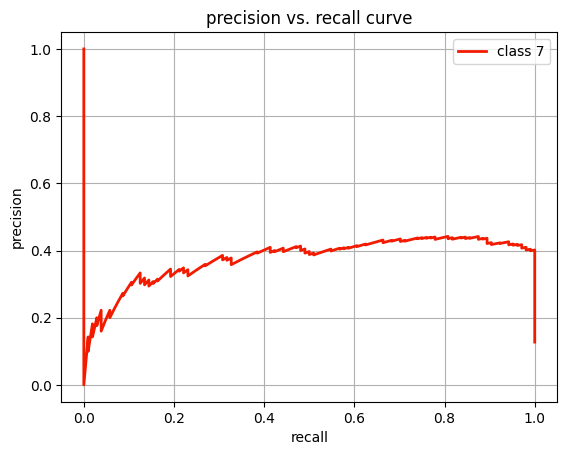

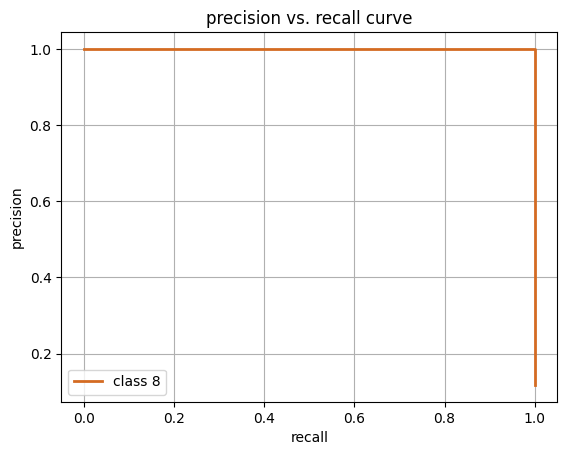

In [13]:
# Построение ROC-кривой
fpr = dict()
tpr = dict()
roc_auc_metrics = []
pr_auc_metrics = []
for i in range(9):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds1_proba[:, i])
    r = lambda: random.randint(0,255)
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i), c='#%02X%02X%02X' % (r(), r(), r()))
    roc_auc_metrics.append(roc_auc_score(y_test[:, i], preds1_proba[:, i]))
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")
    plt.grid()
    plt.show()
# Построение PR-кривой
precision = dict()
recall = dict()
for i in range(9):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], preds1_proba[:, i])
    r = lambda: random.randint(0,255)
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i), c='#%02X%02X%02X' % (r(), r(), r()))
    pr_auc_metrics.append(auc(recall[i], precision[i]))
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.grid()
    plt.show()

In [14]:
#Метрики качества использования логистической регрессии
accuracy = accuracy_score(y_test, preds1)
f1 = f1_score(y_test, preds1, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'F1-мера: {f1}')
print(f'Среднее значение ROC-AUC {np.average(roc_auc_metrics)}')
print(f'Среднее значение PR-AUC {np.average(pr_auc_metrics)}')

Accuracy: 0.5649509803921569
F1-мера: 0.5997445586557294
Среднее значение ROC-AUC 0.9346646140494725
Среднее значение PR-AUC 0.7230216612238107


In [15]:
#Метод опорных векторов
model2 = OneVsRestClassifier(SVC())
model2.fit(x_train, y_train)
preds2 = model2.predict(x_test)

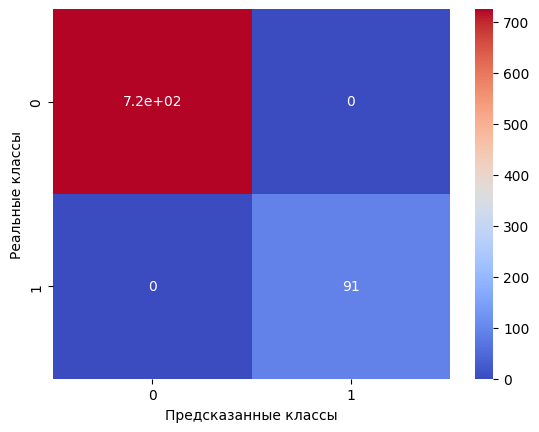

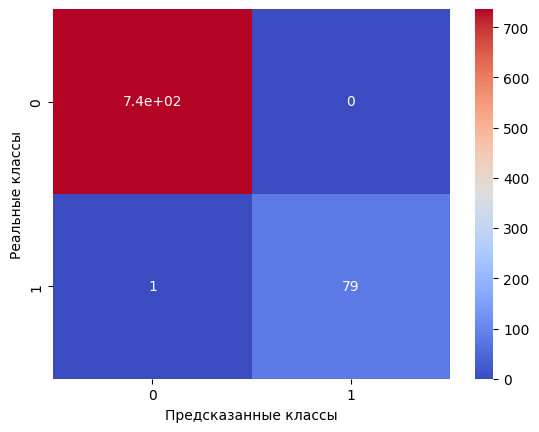

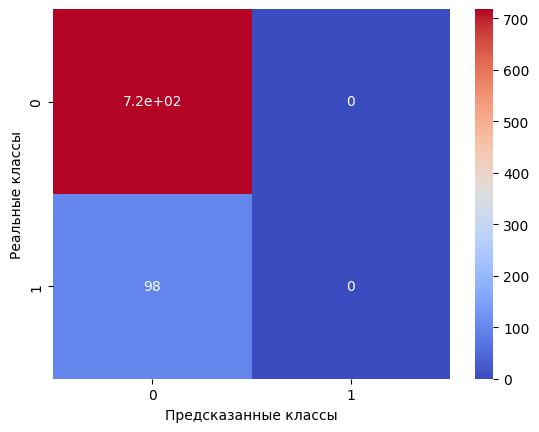

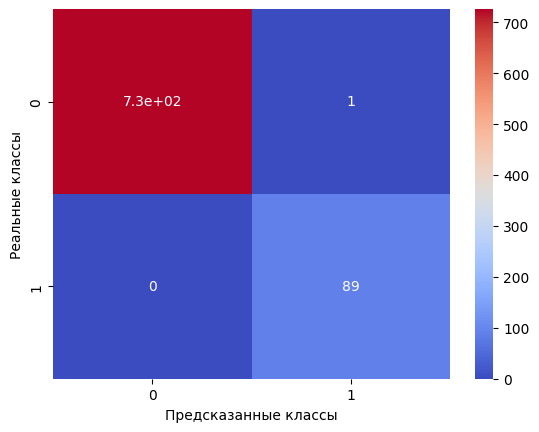

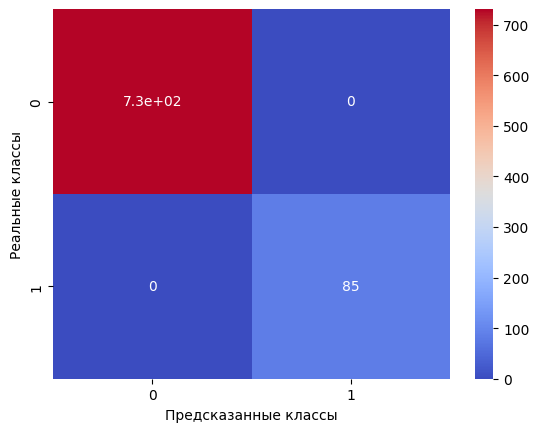

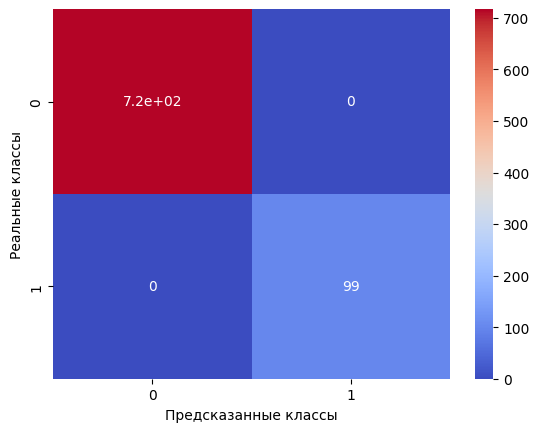

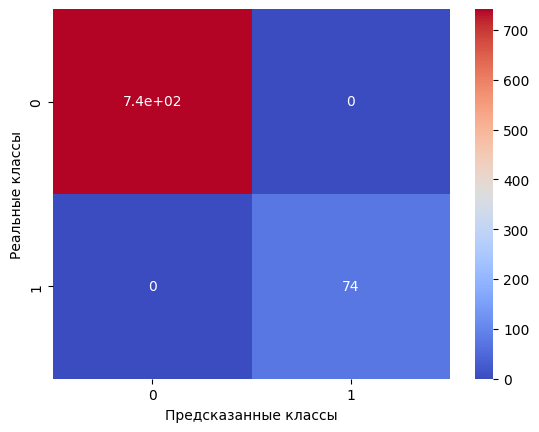

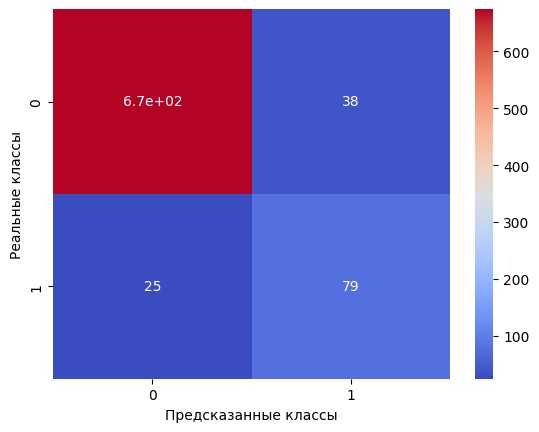

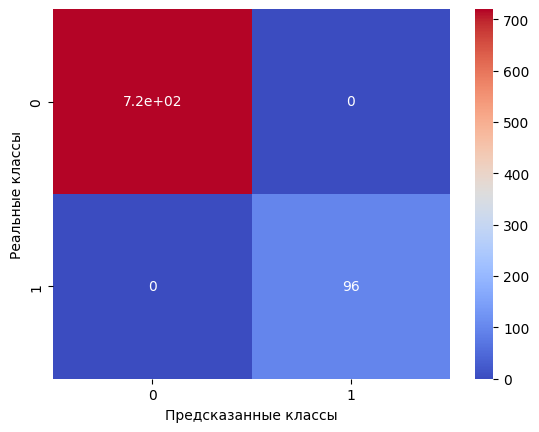

In [16]:
#Матрицы ошибок для задачи классификации по методики OneVsRest
conf_matrix = multilabel_confusion_matrix(y_test, preds2)
for i in range(conf_matrix.shape[0]):
  sns.heatmap(conf_matrix[i], label=True, annot=True, cmap="coolwarm")
  plt.ylabel('Реальные классы')
  plt.xlabel('Предсказанные классы')
  plt.show()

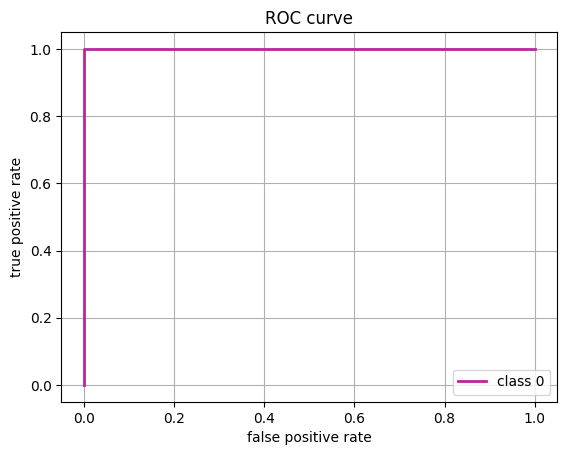

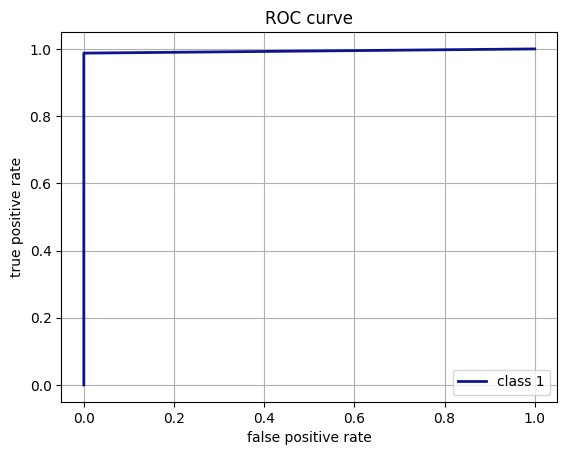

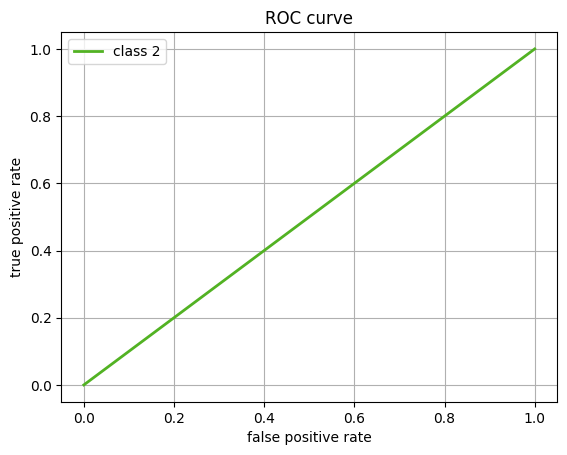

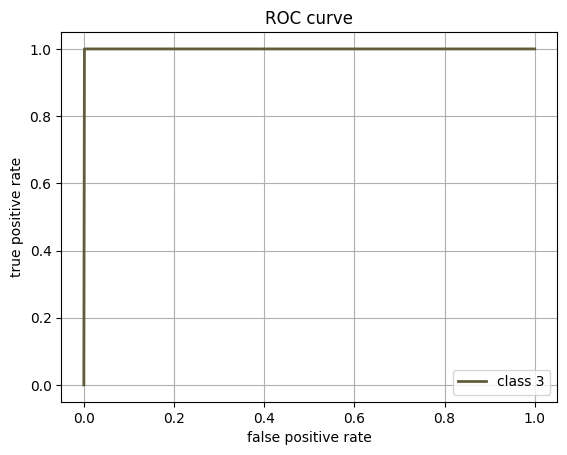

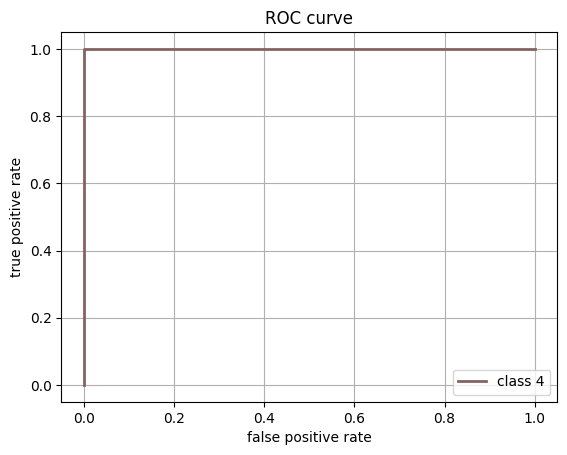

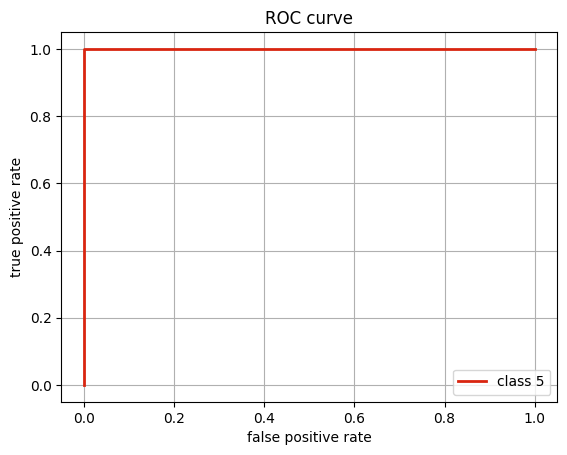

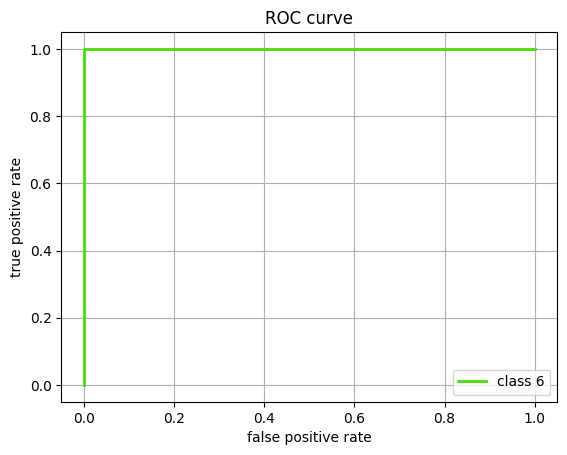

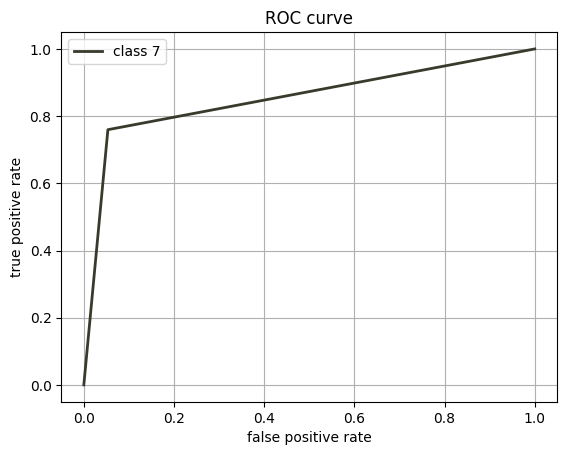

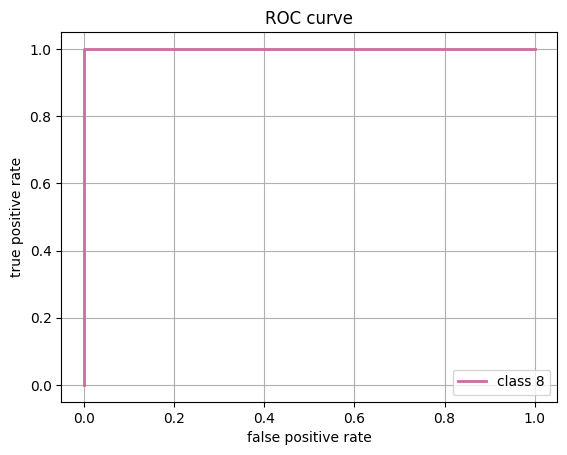

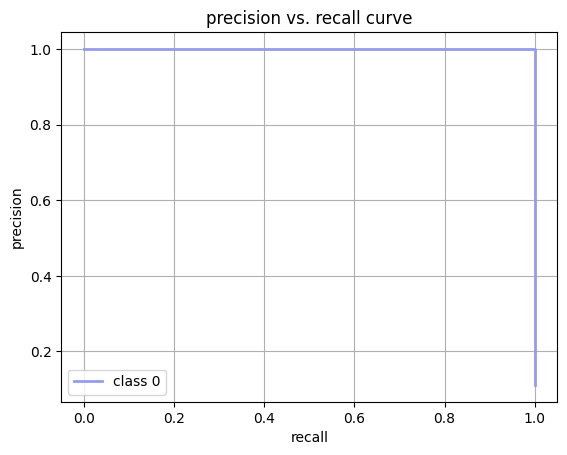

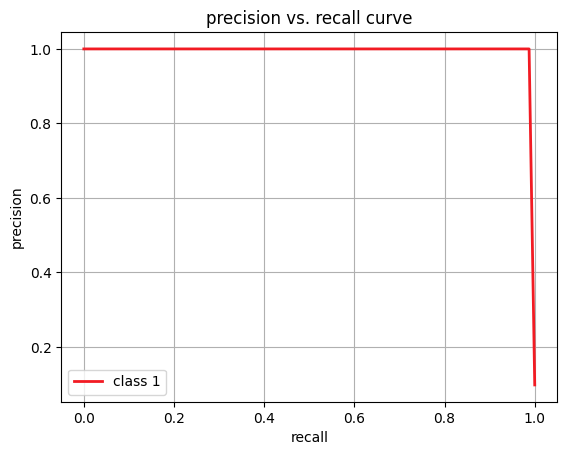

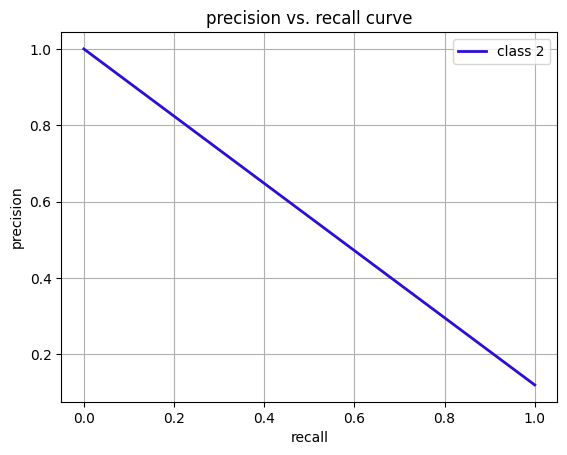

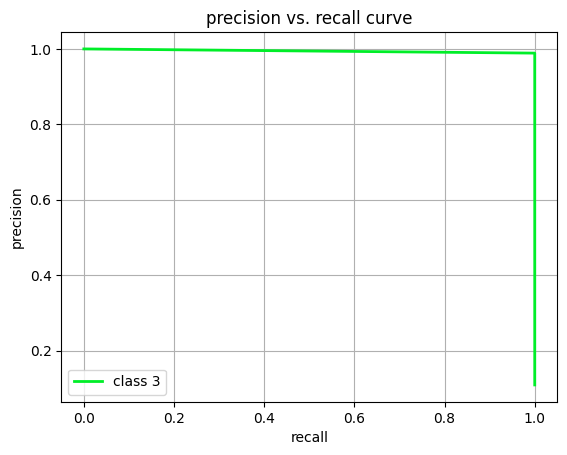

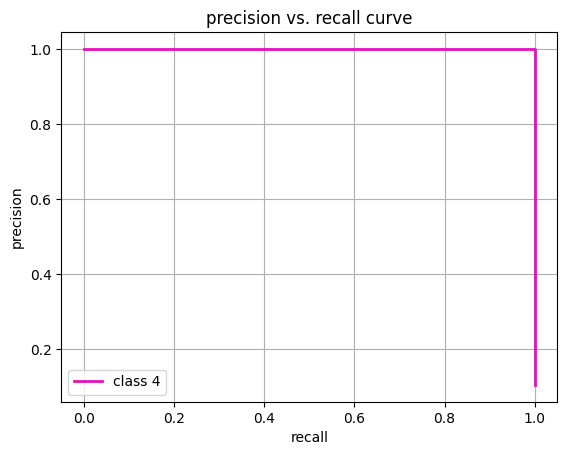

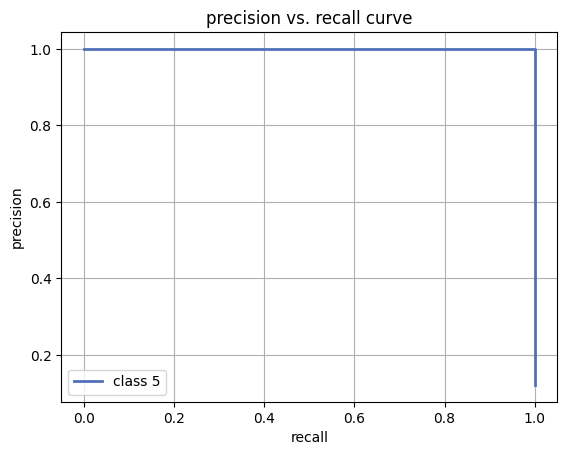

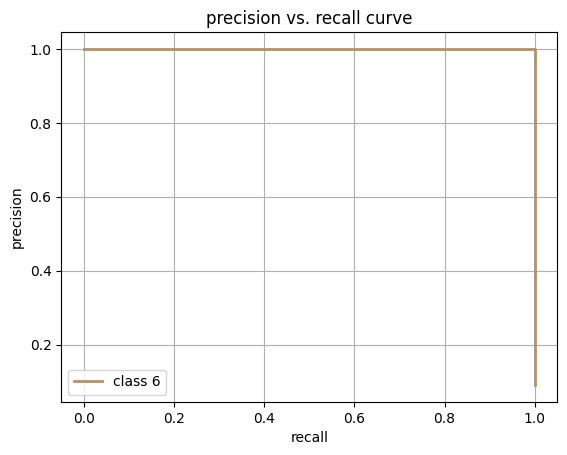

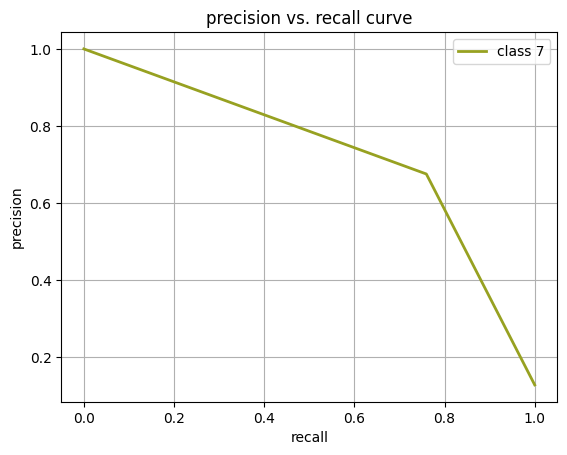

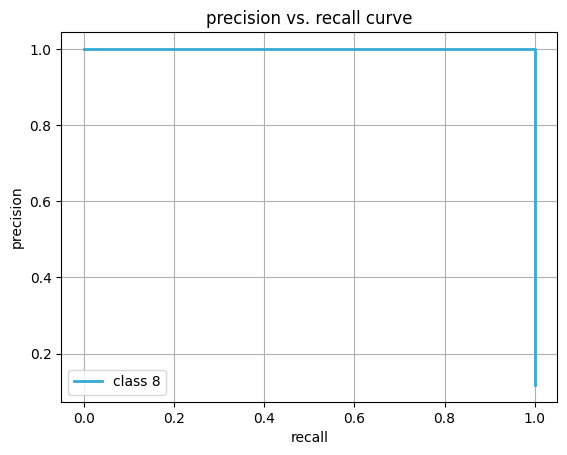

In [17]:
# Построение ROC-кривой
fpr = dict()
tpr = dict()
roc_auc_metrics = []
pr_auc_metrics = []
for i in range(9):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds2[:, i])
    r = lambda: random.randint(0,255)
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i), c='#%02X%02X%02X' % (r(), r(), r()))
    roc_auc_metrics.append(roc_auc_score(y_test[:, i], preds2[:, i]))
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")
    plt.grid()
    plt.show()
# Построение PR-кривой
precision = dict()
recall = dict()
for i in range(9):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], preds2[:, i])
    r = lambda: random.randint(0,255)
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i), c='#%02X%02X%02X' % (r(), r(), r()))
    pr_auc_metrics.append(auc(recall[i], precision[i]))
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.grid()
    plt.show()

In [18]:
#Метрики качества использования метода опорных векторов
accuracy = accuracy_score(y_test, preds2)
f1 = f1_score(y_test, preds2, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'F1-мера: {f1}')
print(f'Среднее значение ROC-AUC {np.average(roc_auc_metrics)}')
print(f'Среднее значение PR-AUC {np.average(pr_auc_metrics)}')

Accuracy: 0.8480392156862745
F1-мера: 0.8423438600716568
Среднее значение ROC-AUC 0.9273538379044499
Среднее значение PR-AUC 0.9201765962795376


In [19]:
#Метод k ближайших соседей
model3 = OneVsRestClassifier(KNeighborsClassifier())
model3.fit(x_train, y_train)
preds3 = model3.predict(x_test)

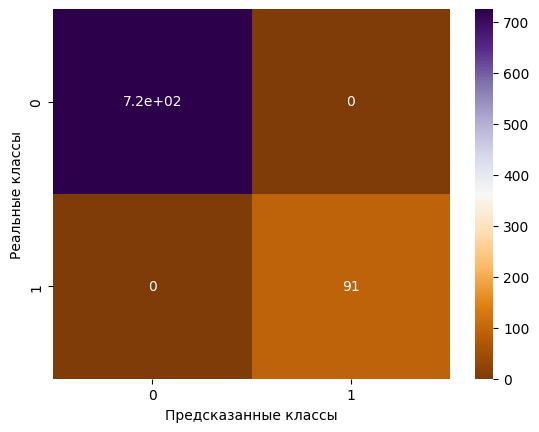

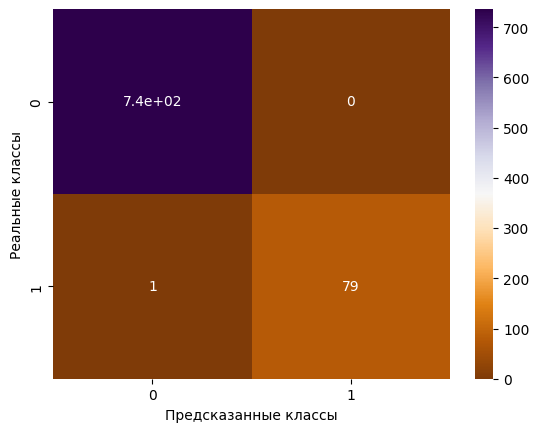

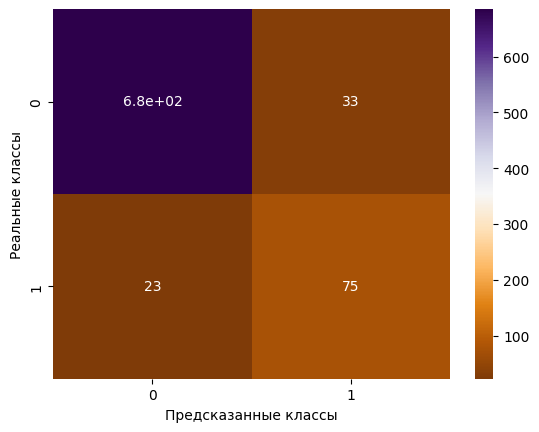

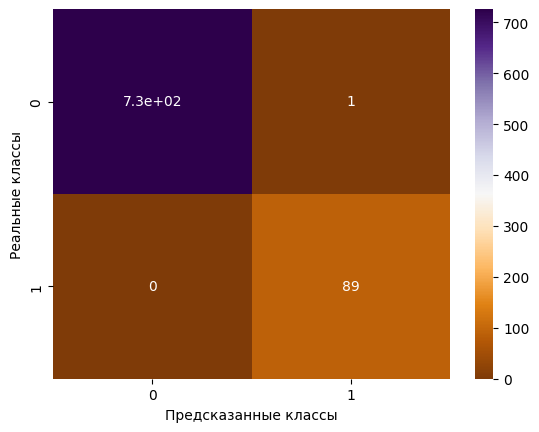

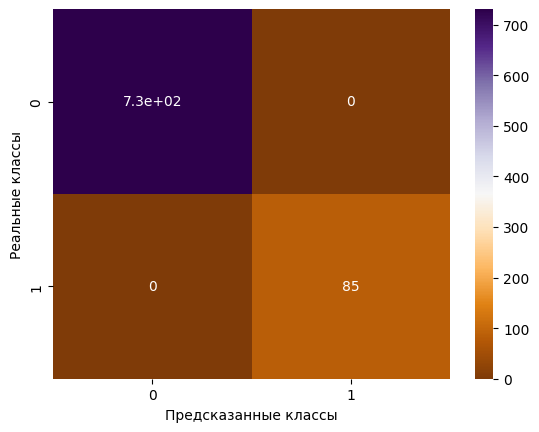

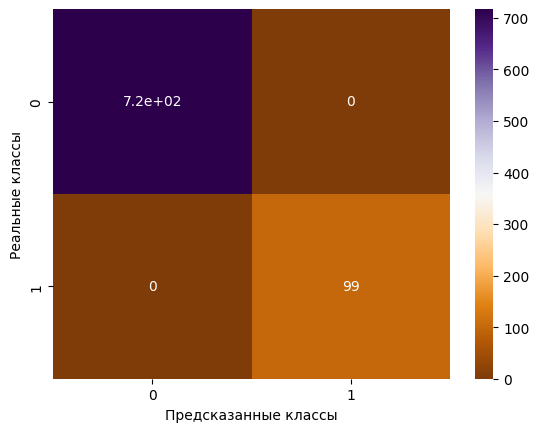

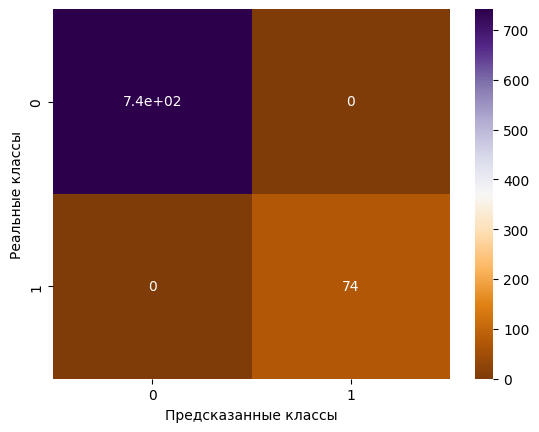

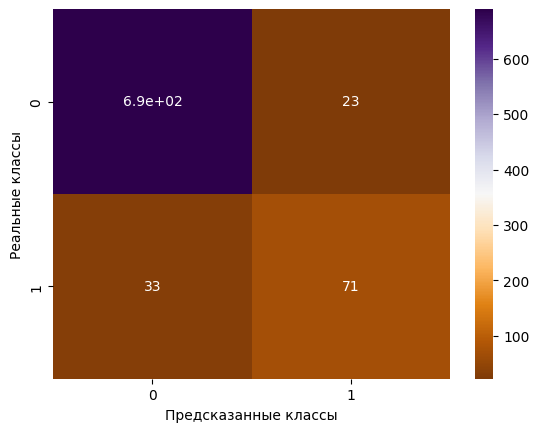

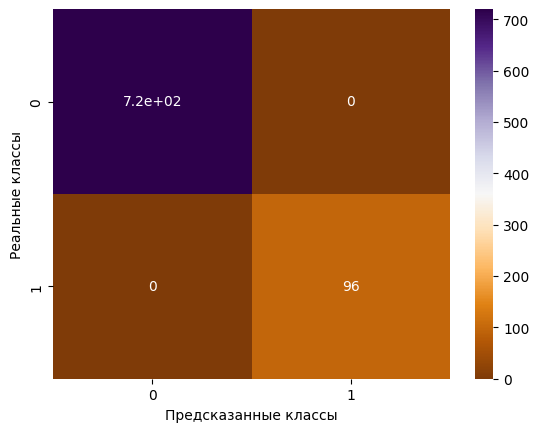

In [20]:
#Матрицы ошибок для задачи классификации по методики OneVsRest
conf_matrix = multilabel_confusion_matrix(y_test, preds3)
for i in range(conf_matrix.shape[0]):
  sns.heatmap(conf_matrix[i], label=True, annot=True, cmap="PuOr")
  plt.ylabel('Реальные классы')
  plt.xlabel('Предсказанные классы')
  plt.show()

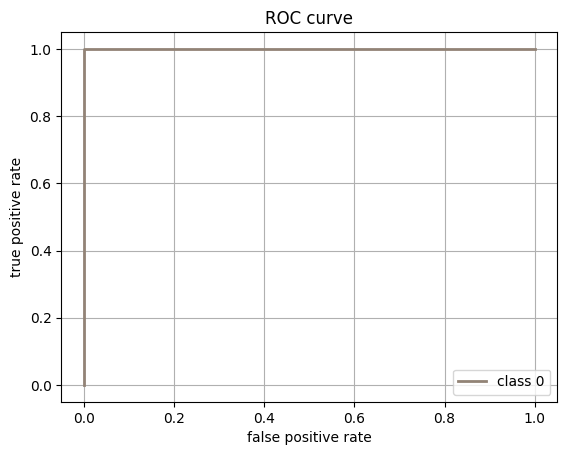

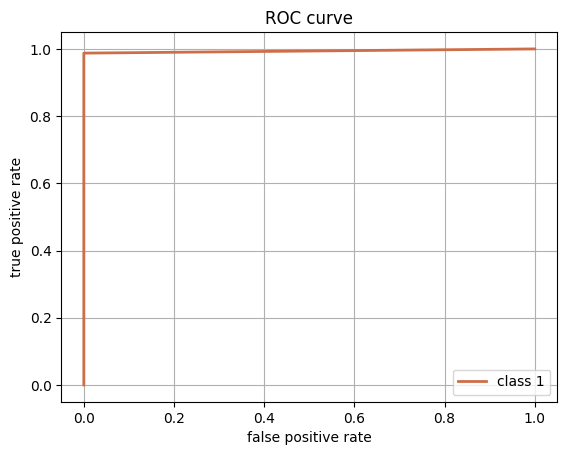

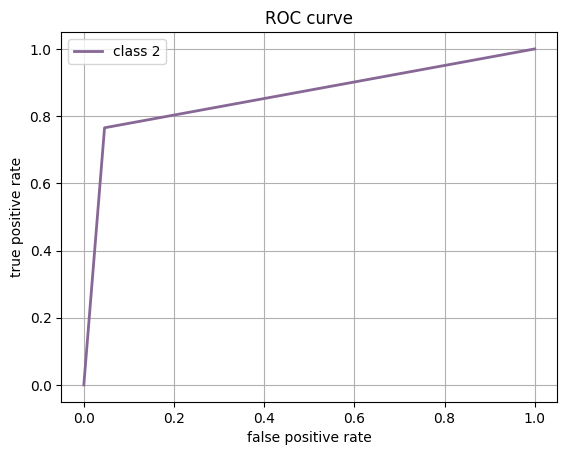

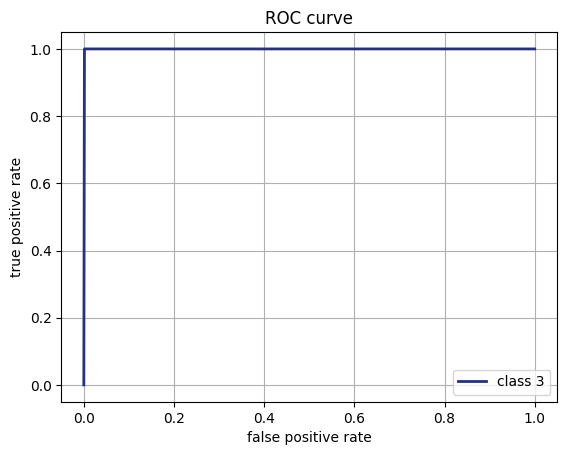

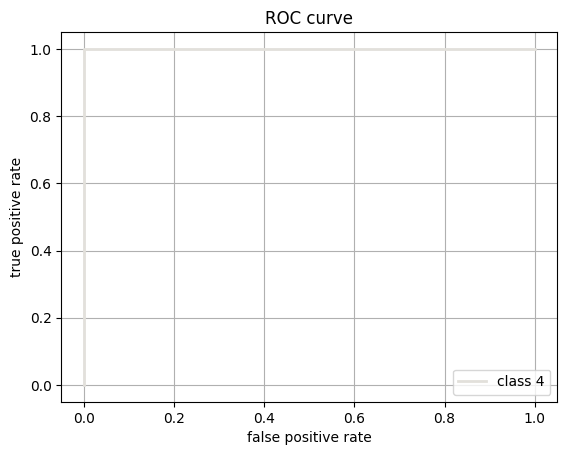

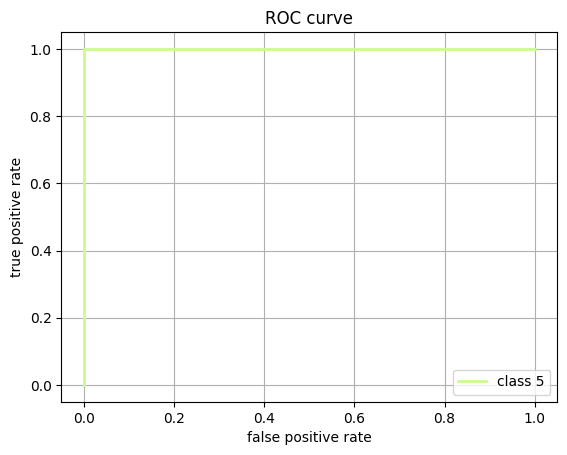

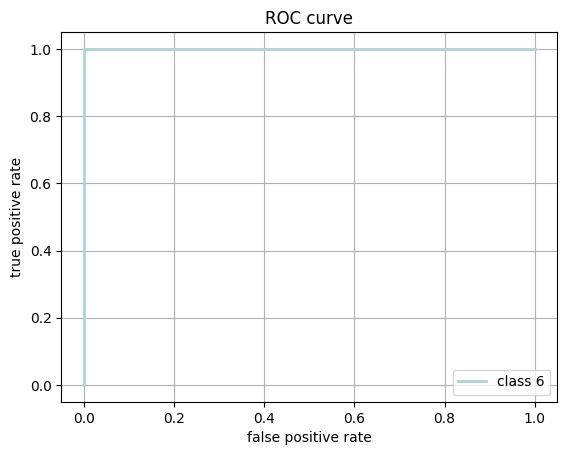

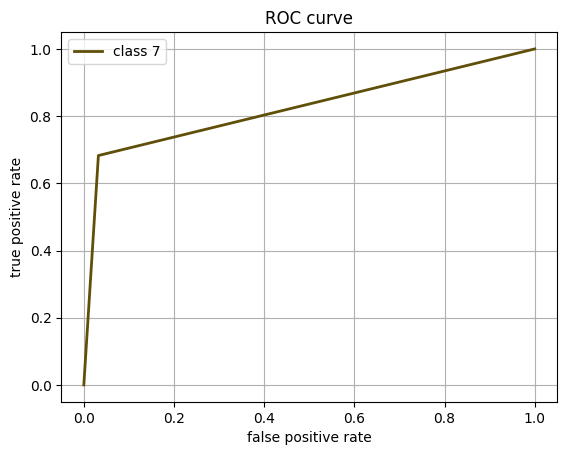

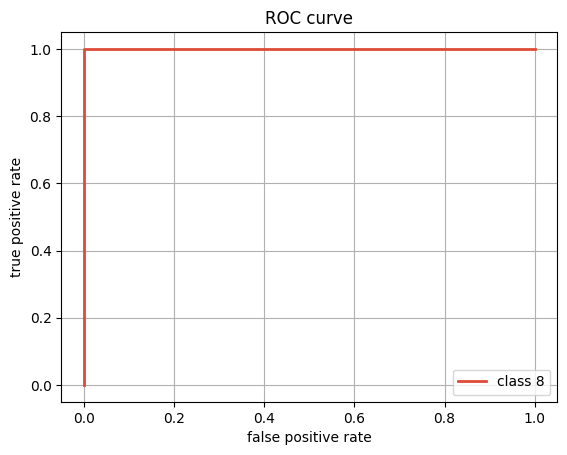

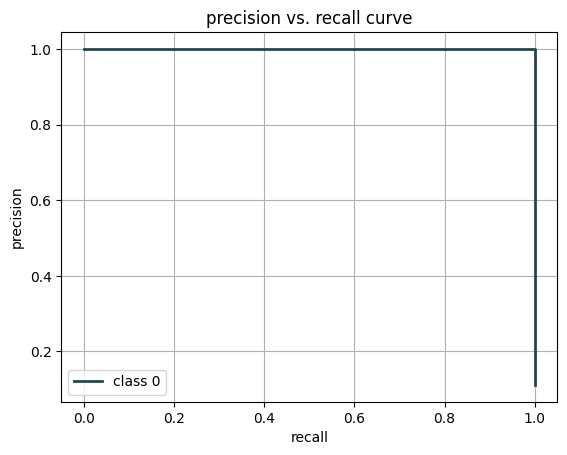

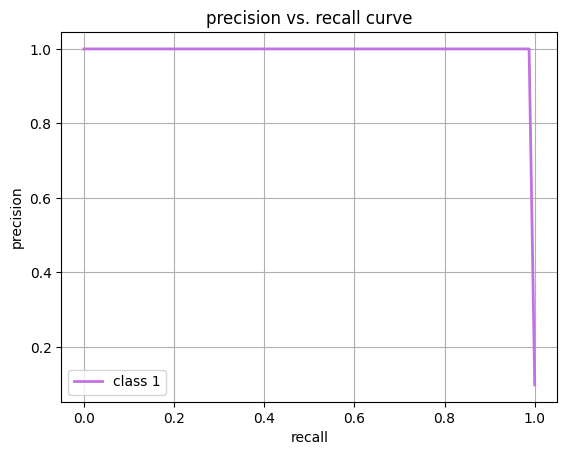

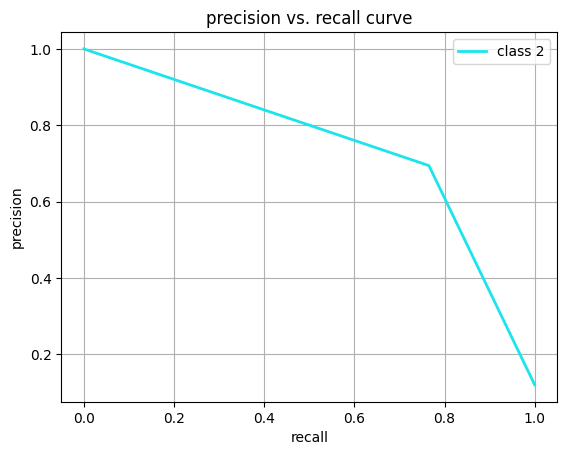

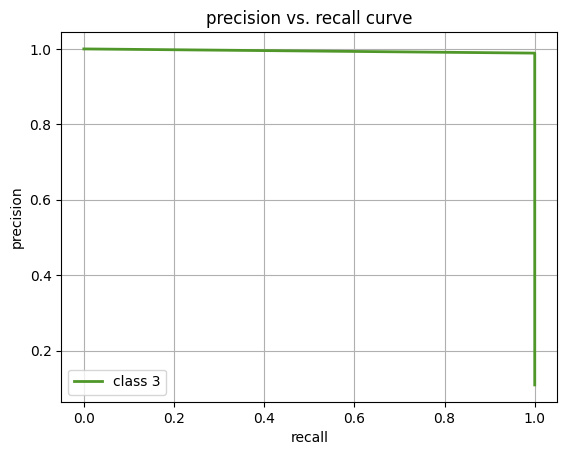

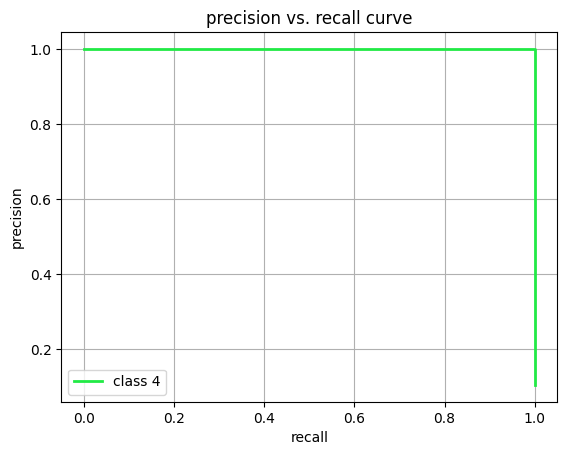

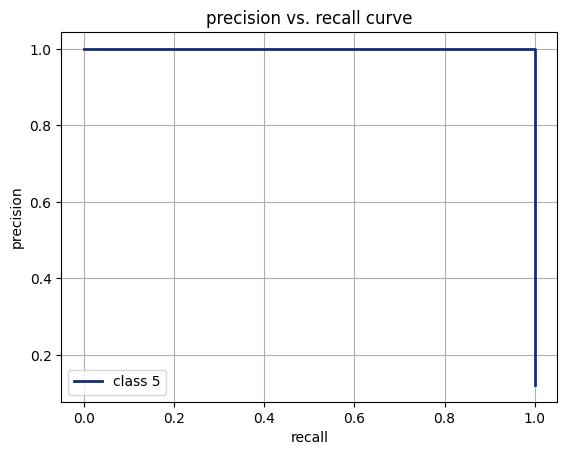

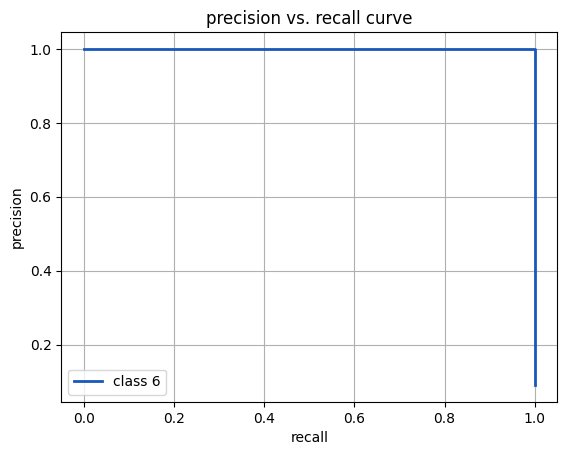

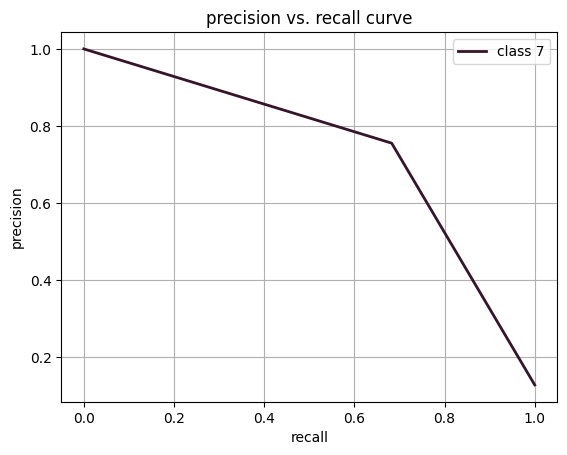

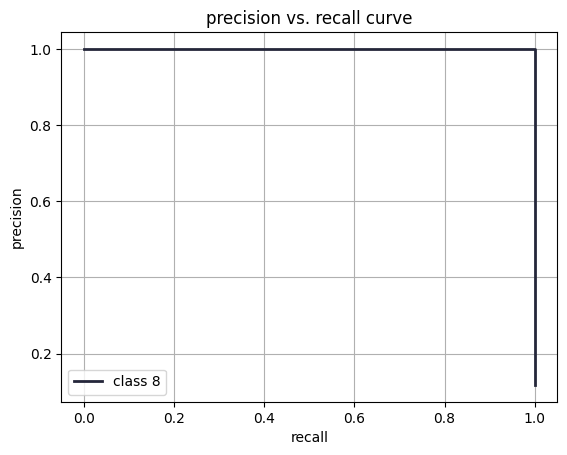

In [21]:
# Построение ROC-кривой
fpr = dict()
tpr = dict()
roc_auc_metrics = []
pr_auc_metrics = []
for i in range(9):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds3[:, i])
    r = lambda: random.randint(0,255)
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i), c='#%02X%02X%02X' % (r(), r(), r()))
    roc_auc_metrics.append(roc_auc_score(y_test[:, i], preds3[:, i]))
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")
    plt.grid()
    plt.show()
# Построение PR-кривой
precision = dict()
recall = dict()
for i in range(9):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], preds3[:, i])
    r = lambda: random.randint(0,255)
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i), c='#%02X%02X%02X' % (r(), r(), r()))
    pr_auc_metrics.append(auc(recall[i], precision[i]))
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.grid()
    plt.show()

In [22]:
#Метрики качества использования метода к ближайших соседей
accuracy = accuracy_score(y_test, preds3)
f1 = f1_score(y_test, preds3, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'F1-мера: {f1}')
print(f'Среднее значение ROC-AUC {np.average(roc_auc_metrics)}')
print(f'Среднее значение PR-AUC {np.average(pr_auc_metrics)}')

Accuracy: 0.9301470588235294
F1-мера: 0.930079326628469
Среднее значение ROC-AUC 0.9642143633750457
Среднее значение PR-AUC 0.9413335474215145


In [23]:
#Оптимизация параметров логистической регрессии
clf1 = GridSearchCV(model1, {
    'estimator__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky'],
    'estimator__tol': np.arange(start = 1e-5, stop = 1e-3, step = 1e2),
    'estimator__C': np.arange(start = 1e0, stop = 1e2, step = 1e0)
}, cv=5, scoring = 'accuracy')
clf1.fit(x_train, y_train)
print(clf1.best_score_)
print(clf1.best_params_)

0.6075451667152079
{'estimator__C': 58.0, 'estimator__solver': 'lbfgs', 'estimator__tol': 1e-05}


In [24]:
#Оптимизация параметров метода опорных векторов
clf2 = GridSearchCV(model2, {
    'estimator__tol': np.arange(start = 1e-5, stop = 1e-3, step = 1e2),
    'estimator__C': np.arange(start = 1e0, stop = 1e2, step = 1e0)
}, cv=5, scoring = 'accuracy')
clf2.fit(x_train, y_train)
print(clf2.best_score_)
print(clf2.best_params_)

0.9084001164986517
{'estimator__C': 50.0, 'estimator__tol': 1e-05}


In [25]:
#Оптимизация параметров метода к ближайших соседей
clf3 = GridSearchCV(model3, {
    'estimator__n_neighbors': [i for i in range(1, 21, 1)]
}, cv=5, scoring = 'accuracy')
clf3.fit(x_train, y_train)
print(clf3.best_score_)
print(clf3.best_params_)

0.9417891938105394
{'estimator__n_neighbors': 13}
